# Importing Libraries

In [1]:
from tensorflow.keras.models import model_from_json
from fer_model import get_fer_model
import tensorflow as tf
import tempfile 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.optimizers import Adam

import os
import zipfile

import tensorflow_model_optimization as tfmot
import pickle

In [2]:
import time
TIMESTAMP = round(time.time())

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Loading the CK+ Dataset

In [4]:
from data import load_ckplus
train_generator = load_ckplus("train")
test_generator = load_ckplus("test")

Found 924 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


# Load Baseline Model

In [5]:
model = get_fer_model()
model.load_weights("weights/model_weights_1618972642.h5")

In [6]:
from evaluation import get_metrics
print("Baseline model performance:")
get_metrics(model, test_generator)

Baseline model performance:


{'size': 16512048,
 'acc': 0.6796875,
 'f_acc': 0.6708333333333333,
 'm_acc': 0.6944444444444444,
 'f_acc_breakdown': [0.5333333333333333,
  0.48484848484848486,
  1.0,
  0.7083333333333334,
  0.7142857142857143,
  0.9,
  0.2,
  0.8666666666666667],
 'f_acc_balanced': 0.6759334415584417,
 'm_acc_breakdown': [0.4166666666666667,
  0.4166666666666667,
  1.0,
  0.9523809523809523,
  0.0,
  0.75,
  0.3333333333333333,
  1.0],
 'm_acc_balanced': 0.6086309523809523}

# Apply Weight Clustering

In [7]:
N_CLUSTERS = 128

In [8]:
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': N_CLUSTERS,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = Adam(lr=0.0005)

clustered_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

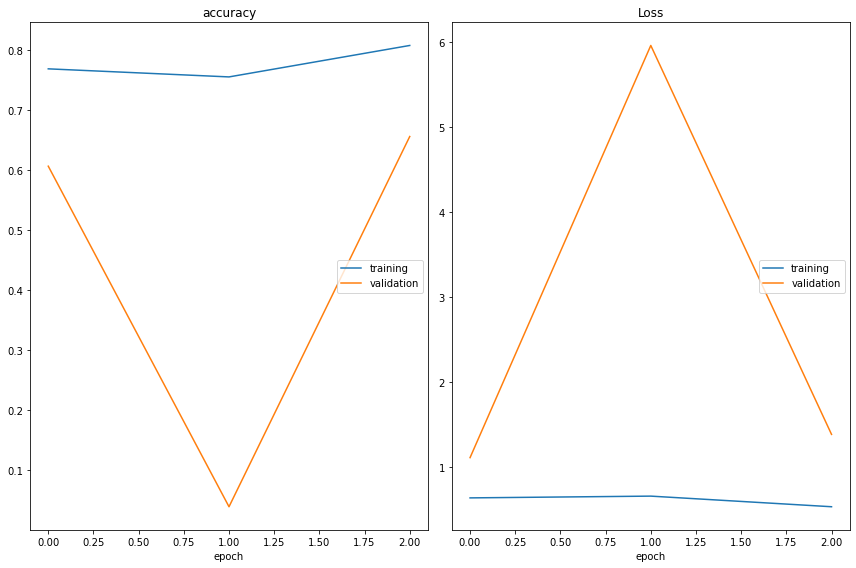

accuracy
	training         	 (min:    0.756, max:    0.808, cur:    0.808)
	validation       	 (min:    0.039, max:    0.656, cur:    0.656)
Loss
	training         	 (min:    0.534, max:    0.659, cur:    0.534)
	validation       	 (min:    1.111, max:    5.959, cur:    1.385)

Epoch 00003: val_accuracy improved from 0.60677 to 0.65625, saving model to weights/clustered_model_c128_1619022574.h5
28/28 [==============================] - 42s 2s/step - loss: 0.5337 - accuracy: 0.8080 - val_loss: 1.3848 - val_accuracy: 0.6562


In [9]:
# Fine-Tuning 
epochs = 3
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = test_generator.n//test_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint_name = "weights/clustered_model_c%d_%s.h5" % (N_CLUSTERS, TIMESTAMP)
checkpoint = ModelCheckpoint(checkpoint_name, 
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=True, 
                             mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), 
             checkpoint, 
             reduce_lr, 
             ]

clustered_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = test_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

# Only use the best weights 
clustered_model.load_weights(checkpoint_name)

In [10]:
clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)

# Evaluate Clustered Model

In [11]:
print("Model performance after weight clustering:")
metrics = get_metrics(clustered_model, test_generator)
metrics

Model performance after weight clustering:


{'size': 5265774,
 'acc': 0.65625,
 'f_acc': 0.5916666666666667,
 'm_acc': 0.7638888888888888,
 'f_acc_breakdown': [0.9666666666666667,
  0.0,
  0.0,
  0.625,
  0.0,
  1.0,
  0.0,
  0.8666666666666667],
 'f_acc_balanced': 0.4322916666666667,
 'm_acc_breakdown': [0.8055555555555556, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 'm_acc_balanced': 0.4756944444444444}

### Store results

In [12]:
with open("logs/clustered_model_metrics_c%d_%s" % (N_CLUSTERS, TIMESTAMP), 
          'wb') as clustered_model_metrics_file:
        pickle.dump(metrics, clustered_model_metrics_file)

# Apply Quantisation to Clustered Model 

In [13]:
converter = tf.lite.TFLiteConverter.from_keras_model(clustered_model)
# This optimisation includes the quantisation 
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_clustered_tflite_model = converter.convert()

# Evaluate Quantised and Clustered Model

In [14]:
from evaluation import get_metrics_quantised
metrics = get_metrics_quantised(quantized_and_clustered_tflite_model, test_generator)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.


In [15]:
print("Clustered and quantised model performance:")
metrics

Clustered and quantised model performance:


{'size': 3804505,
 'acc': 0.6588541666666666,
 'f_acc': 0.5958333333333333,
 'm_acc': 0.7638888888888888,
 'f_acc_breakdown': [0.9666666666666667,
  0.0,
  0.0,
  0.6666666666666666,
  0.0,
  1.0,
  0.0,
  0.8666666666666667],
 'f_acc_balanced': 0.4375,
 'm_acc_breakdown': [0.8055555555555556, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
 'm_acc_balanced': 0.4756944444444444}

### Store results

In [16]:
with open("logs/clustered_and_quantised_model_metrics_c%d_%s" % (N_CLUSTERS, TIMESTAMP), 
          'wb') as clustered_and_quantised_model_metrics_file:
        pickle.dump(metrics, clustered_and_quantised_model_metrics_file)